### Assignment Requirements
Predict the class of breast cancer (malignant or ‘bad’ versus benign or ‘good’) from the features of images taken from breast samples. 
Ten biological attributes of the cancer cell nuclei have been calculated from the images.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
cancer = pd.read_csv("cancer.data", header = None)
cancer.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [3]:
# changing index cols with rename() 
cancer = cancer.rename(columns = {"0": "Sample_code_number", 
                                  "1": "Clump_Thickness", 
                                  "2": "Uniformity_of_Cell_Size",
                                  "3": "Uniformity_of_Cell_Shape",
                                  "4": "Marginal_Adhesion",
                                  "5": "Single_Epithelial_Cell_Size",
                                  "6": "Bare_Nuclei",
                                  "7": "Bland_Chromatin",
                                  "8": "Normal_Nucleoli",
                                  "9": "Mitoses",
                                  "10": "Class"}) 
  
# changing columns using .columns() 
cancer.columns = ["Sample_code_number", 
                     "Clump_Thickness", 
                     "Uniformity_of_Cell_Size", 
                     "Uniformity_of_Cell_Shape", 
                     "Marginal_Adhesion", 
                     "Single_Epithelial_Cell_Size", 
                     "Bare_Nuclei", 
                     "Bland_Chromatin", 
                     "Normal_Nucleoli", 
                     "Mitoses", 
                     "Class"]
cancer.columns

Index(['Sample_code_number', 'Clump_Thickness', 'Uniformity_of_Cell_Size',
       'Uniformity_of_Cell_Shape', 'Marginal_Adhesion',
       'Single_Epithelial_Cell_Size', 'Bare_Nuclei', 'Bland_Chromatin',
       'Normal_Nucleoli', 'Mitoses', 'Class'],
      dtype='object')

In [4]:
# Replace the '?'s with NaN
cancer = cancer.replace('?', np.NaN)


# Impute the missing values with mode imputation
cancer.fillna(cancer.mode(), inplace = True)

cancer.isnull().count()

Sample_code_number             699
Clump_Thickness                699
Uniformity_of_Cell_Size        699
Uniformity_of_Cell_Shape       699
Marginal_Adhesion              699
Single_Epithelial_Cell_Size    699
Bare_Nuclei                    699
Bland_Chromatin                699
Normal_Nucleoli                699
Mitoses                        699
Class                          699
dtype: int64

In [5]:
# Iterate over each column of cancer
for col in cancer:
    if cancer[col].dtypes == 'object':
        cancer = cancer.fillna(cancer[col].value_counts().index[0])

In [6]:
print(cancer.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Sample_code_number           699 non-null    int64 
 1   Clump_Thickness              699 non-null    int64 
 2   Uniformity_of_Cell_Size      699 non-null    int64 
 3   Uniformity_of_Cell_Shape     699 non-null    int64 
 4   Marginal_Adhesion            699 non-null    int64 
 5   Single_Epithelial_Cell_Size  699 non-null    int64 
 6   Bare_Nuclei                  699 non-null    object
 7   Bland_Chromatin              699 non-null    int64 
 8   Normal_Nucleoli              699 non-null    int64 
 9   Mitoses                      699 non-null    int64 
 10  Class                        699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB
None


In [7]:
cancer.describe()

,Sample_code_number,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [8]:
le = LabelEncoder()

# Iterate over all the values of each column and extract their dtypes
for col in cancer:
    if cancer[col].dtype == 'object':
        cancer[col] = le.fit_transform(cancer[col])

In [9]:
cancer["Class"].value_counts()

2    458
4    241
Name: Class, dtype: int64

### 1. What are the factors that predict malignant cancer? (i.e. which variables significantly predict malignancy, p < 0.05)

In [10]:
cancer.groupby("Class").mean()

,Sample_code_number,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses
Class,,,,,,,,,,
2,1.107591e+06,2.956332,1.325328,1.443231,1.364629,2.120087,0.401747,2.100437,1.290393,1.063319
4,1.003505e+06,7.195021,6.572614,6.560166,5.547718,5.298755,2.684647,5.979253,5.863071,2.589212


Text(0, 0.5, 'Classification Frequency')

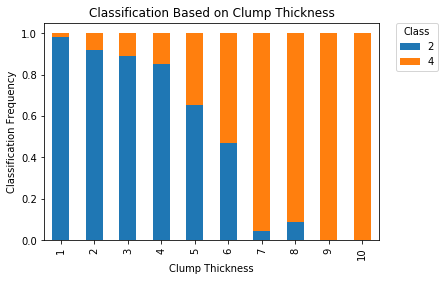

In [11]:
table_1 = pd.crosstab(cancer["Clump_Thickness"], cancer["Class"])
table_1.div(table_1.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True)
plt.title('Classification Based on Clump Thickness')
plt.legend(title = 'Class', bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
plt.xlabel('Clump Thickness')
plt.ylabel('Classification Frequency')

Text(0, 0.5, 'Classification Frequency')

<Figure size 864x360 with 0 Axes>

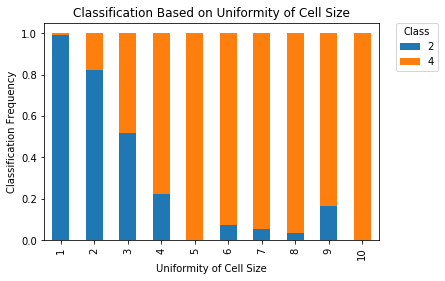

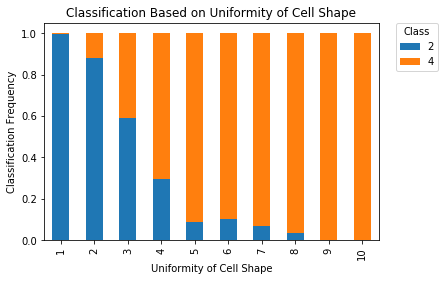

In [12]:
table1 = pd.crosstab(cancer["Uniformity_of_Cell_Size"], cancer["Class"])
table2 = pd.crosstab(cancer["Uniformity_of_Cell_Shape"], cancer["Class"])

fig, ax = plt.subplots(1, 0, figsize = (12, 5))
table1.div(table1.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True)
plt.legend(title = 'Class', bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
plt.title("Classification Based on Uniformity of Cell Size")
plt.xlabel('Uniformity of Cell Size')
plt.ylabel('Classification Frequency')

table2.div(table2.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True)
plt.legend(title = 'Class', bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
plt.title("Classification Based on Uniformity of Cell Shape")
plt.xlabel('Uniformity of Cell Shape')
plt.ylabel('Classification Frequency')

Text(0, 0.5, 'Classification Frequency')

<Figure size 864x360 with 0 Axes>

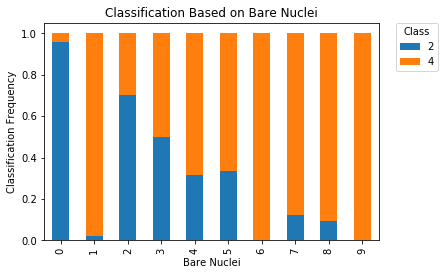

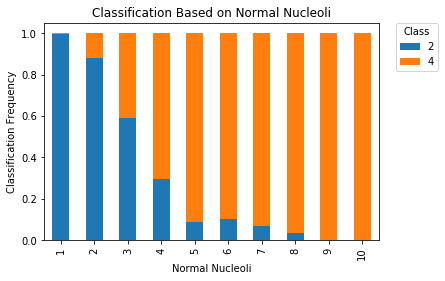

In [13]:
table3 = pd.crosstab(cancer["Bare_Nuclei"], cancer["Class"])
table4 = pd.crosstab(cancer["Normal_Nucleoli"], cancer["Class"])

fig, ax = plt.subplots(1, 0, figsize = (12, 5))
table3.div(table3.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True)
plt.legend(title = 'Class', bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
plt.title("Classification Based on Bare Nuclei")
plt.xlabel('Bare Nuclei')
plt.ylabel('Classification Frequency')

table2.div(table2.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True)
plt.legend(title = 'Class', bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
plt.title("Classification Based on Normal Nucleoli")
plt.xlabel('Normal Nucleoli')
plt.ylabel('Classification Frequency')

Text(0, 0.5, 'Classification Frequency')

<Figure size 864x360 with 0 Axes>

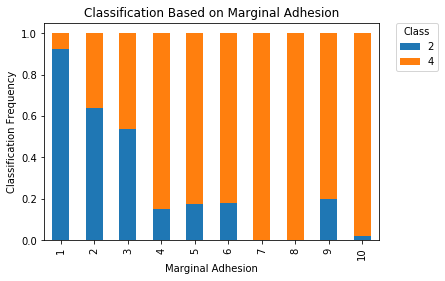

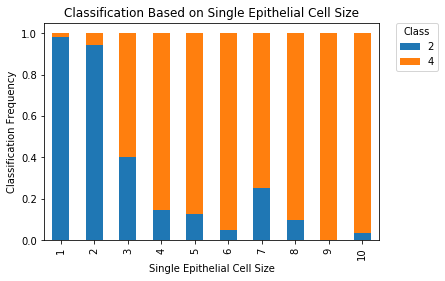

In [14]:
table5 = pd.crosstab(cancer["Marginal_Adhesion"], cancer["Class"])
table6 = pd.crosstab(cancer["Single_Epithelial_Cell_Size"], cancer["Class"])

fig, ax = plt.subplots(1, 0, figsize = (12, 5))
table5.div(table5.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True)
plt.legend(title = 'Class', bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
plt.title("Classification Based on Marginal Adhesion")
plt.xlabel('Marginal Adhesion')
plt.ylabel('Classification Frequency')

table6.div(table6.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True)
plt.legend(title = 'Class', bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
plt.title("Classification Based on Single Epithelial Cell Size")
plt.xlabel('Single Epithelial Cell Size')
plt.ylabel('Classification Frequency')

Text(0, 0.5, 'Classification Frequency')

<Figure size 864x360 with 0 Axes>

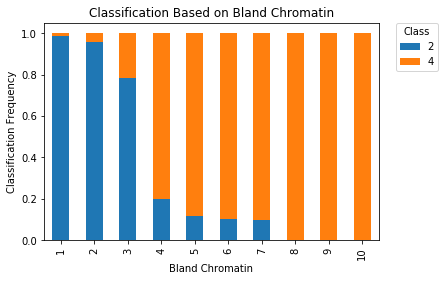

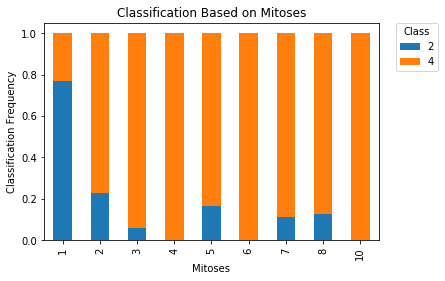

In [15]:
table7 = pd.crosstab(cancer["Bland_Chromatin"], cancer["Class"])
table8 = pd.crosstab(cancer["Mitoses"], cancer["Class"])

fig, ax = plt.subplots(1, 0, figsize = (12, 5))
table7.div(table7.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True)
plt.legend(title = 'Class', bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
plt.title("Classification Based on Bland Chromatin")
plt.xlabel('Bland Chromatin')
plt.ylabel('Classification Frequency')

table8.div(table8.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True)
plt.legend(title = 'Class', bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
plt.title("Classification Based on Mitoses")
plt.xlabel('Mitoses')
plt.ylabel('Classification Frequency')

In [16]:
# Creating the target variable for the test and training sets of data
X = cancer.drop(['Class', 'Sample_code_number', 'Uniformity_of_Cell_Size', 'Marginal_Adhesion', 'Single_Epithelial_Cell_Size', 'Bare_Nuclei', 'Mitoses'], axis = 1) # , 'Uniformity_of_Cell_Size', 'Marginal_Adhesion', 'Single_Epithelial_Cell_Size', 'Bare_Nuclei', 'Mitoses'
y = cancer["Class"]

# Calculating the p-value
chi2_score, pval = chi2(X, y)
chi2_scor = pd.DataFrame(chi2_score, X.columns, columns = ["chi2-score"])
chi2_scor

,chi2-score
Clump_Thickness,642.197052
Uniformity_of_Cell_Shape,1289.040711
Bland_Chromatin,691.078215
Normal_Nucleoli,1151.664431


In [17]:
p_vals = pd.DataFrame(pval, X.columns, columns = ["p-value"])
p_vals

,p-value
Clump_Thickness,1.112024e-141
Uniformity_of_Cell_Shape,2.721677e-282
Bland_Chromatin,2.605089e-152
Normal_Nucleoli,1.950505e-252


### Variables that predict malignant cancer (based on graphs and the p-value) :
1. Clump Thickness
2. Uniformity of Cell Shape
3. Normal Nucleoli
4. Bland Chromatin

### 2. Create a classification report and confusion matrix of predicted and observed values. What is the accuracy, precision, recall and F1-score of the model on the (a) training and (b) test data?

In [24]:
from sklearn import metrics

In [25]:
# Split the dataset into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Instantiate MinMaxScaler and use it to rescale X_train and X_test
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.fit_transform(X_test)

# Instantiate a LogisticRegression classifier with default parameter values
logreg = LogisticRegression()

# Fit logreg to the train set
logreg.fit(rescaledX_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
# logreg to predict instances from the test set and store it
y_pred = logreg.predict(rescaledX_test)

# Getting the accuracy score of logreg model and print it
print("Accuracy of logistic regression classifier: ", logreg.score(rescaledX_test, y_test))

# Creating a classification report
print(classification_report(y_test, y_pred))

# Printing the confusion matrix of the logreg model
metrics.confusion_matrix(y_test, y_pred)

Accuracy of logistic regression classifier:  0.9476190476190476
              precision    recall  f1-score   support

           2       0.95      0.98      0.96       143
           4       0.95      0.88      0.91        67

    accuracy                           0.95       210
   macro avg       0.95      0.93      0.94       210
weighted avg       0.95      0.95      0.95       210



array([[140,   3],
       [  8,  59]])

### The classification report indicates the key metrics in a classification problem.
#### This information is given by the precision, recall, f1-score and support for each class on the model.

- The "recall" indicates "how many of this class you find over the whole number of element of this class".

- The precision will be "how many are correctly classified among that class"

- The f1-score is the harmonic mean between precision & recall

- The support is the number of occurence of the given class in the dataset. Thus 143 of class 2, and 67 of class 4, which is quite an imbalanced dataset due to the difference of 76, more 50% of the data.

With precision and recall, these are highly used for imbalanced dataset because in a highly imbalanced dataset, a 99% accuracy can be meaningless.

### Confusion Matrix
- True Positive (TP) : Observation is positive, and is predicted to be positive.
- False Negative (FN) : Observation is positive, but is predicted negative.
- True Negative (TN) : Observation is negative, and is predicted to be negative.
- False Positive (FP) : Observation is negative, but is predicted positive.

In [30]:
# Define the grid of values for tol and max_iter
tol = ([0.01, 0.001, 0.0001])
max_iter = ([100, 150, 200])

# Create a dictionary where tol and max_iter are keys and the lists of their values are corresponding values
param_grid = dict(tol = tol, max_iter = max_iter)
grid_model = GridSearchCV(estimator = logreg, param_grid = param_grid, cv = 5)

# Use scaler to rescale X and assign it to rescaledX
rescaledX = scaler.fit_transform(X_train)

# Fit data to grid_model
grid_model_result = grid_model.fit(rescaledX, y_train)

# Summarize results
best_score, best_params = grid_model_result.best_score_, grid_model_result.best_params_
print("Best: %f using %s" % (best_score, best_params))

Best: 0.952956 using {'max_iter': 100, 'tol': 0.01}


### 3. Plot a Receiver Operating Characteristic (ROC) curve on the test data.

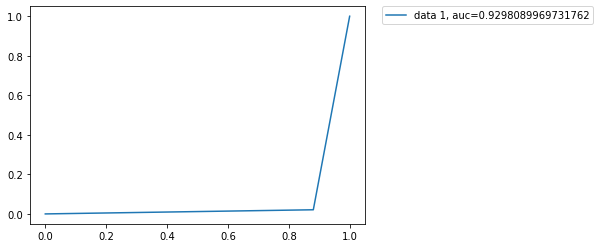

In [45]:
y_pred = logreg.predict(rescaledX_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label = 2)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label = "data 1, auc="+str(auc))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

/home/phathu/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


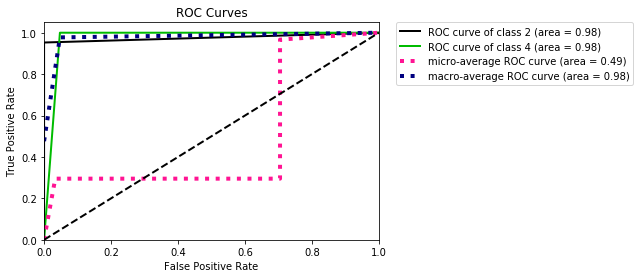

In [46]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = y_pred # ground truth labels
y_probas = logreg.predict_proba(rescaledX_test) # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### 4. What is overdispersion?

Overdispersion occurs when the variance of the observed target value is larger than what the predicted would be, by the Poisson distribution. The greater variability than predicted by the generalized linear model random component reflects overdispersion.